# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -2.660029  0.133002  0.0  0.349423  2.881125  0.011396  1  1  11.308715   
1  0.303099 -0.096276  0.0  0.650689 -1.314666  0.660725  3  2  23.865494   
2 -1.987537 -0.018452  1.0  0.942835 -1.423005  0.626783  2  3  35.596730   
3 -0.647380 -0.930885  1.0  0.532224  0.345671  1.504687  1  3  31.306148   
4 -2.768078 -0.959368  1.0  0.143088 -0.895300  1.119213  3  2  30.486455   

            y  
0   29.058203  
1  269.322524  
2  129.988583  
3  123.386062  
4 -101.901530  
True causal estimate is 9.804661908578167


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

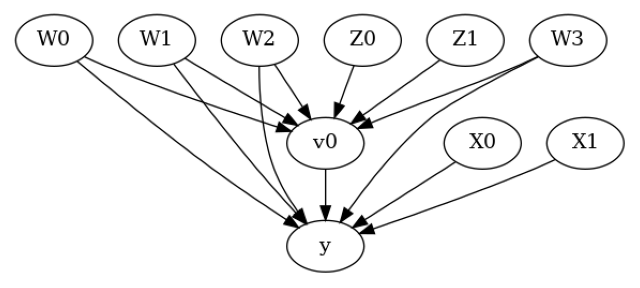

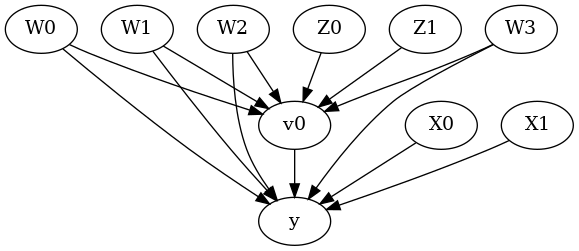

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 9.804657259434133



## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 16.468341382616863
Effect estimates: [[15.31784574]
 [16.71248285]
 [20.6218287 ]
 [13.35973197]
 [22.55327804]
 [28.26077044]
 [21.95199211]
 [ 8.49780097]
 [10.72990499]
 [12.99184339]
 [20.00300677]
 [ 6.22235731]
 [17.66899828]
 [11.68265204]
 [20.14003994]
 [12.12881575]
 [21.5390724 ]
 [13.63809793]
 [18.15491134]
 [12.81892431]
 [17.93543952]
 [17.78777526]
 [26.13923394]
 [22.42774547]
 [13.10580684]
 [21.30451022]
 [13.23544044]
 [13.89277196]
 [20.55540145]
 [20.17504659]
 [ 8.63784325]
 [15.44436893]
 [23.34873702]
 [11.590

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 9.804661908578167


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: 

## Estimate
Mean value: 9.738532788086479
Effect estimates: [[ 1.56152502]
 [10.48604929]
 [ 3.11700502]
 ...
 [15.96304366]
 [ 4.8308118 ]
 [-1.04223798]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 9.708547405541886
Effect estimates: [[ 1.49519076]
 [10.45944358]
 [ 3.05760873]
 ...
 [15.96074984]
 [ 4.77908467]
 [-1.11998875]]
95.0% confidence interval: [[[ 1.22986901 10.40385863  2.8739593  ... 15.92185255  4.66369779
   -1.41870611]]

 [[ 1.60574122 10.64260845  3.14682357 ... 16.34160092  4.83306484
   -1.08405992]]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[15.84385362]
 [16.72210417]
 [13.68235016]
 [15.07603252]
 [11.51593467]
 [16.61457254]
 [11.06917597]
 [11.03355846]
 [15.67509772]
 [14.05411654]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -1.267241  0.216893  0.0  0.355347 -1.193584 -0.867574  1.646664   
1    -0.627665 -2.843676  0.0  0.926958 -0.593089 -0.606940  0.932697   
2     0.204294 -1.017858  0.0  0.572382 -0.540633  0.257471  1.575647   
3    -0.313476 -0.881910  0.0  0.243562 -0.040857 -1.167681  1.948064   
4    -1.114814 -0.920758  0.0  0.489717 -1.659916 -0.307246 -0.127069   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -1.795511 -0.110027  0.0  0.016213 -0.302470 -0.975261 -0.319532   
9996  0.256138 -1.143493  1.0  0.637714  0.761290  0.263316  2.791181   
9997  0.775051 -1.465467  0.0  0.735787 -0.204357  0.860823  0.304589   
9998 -1.075250  0.621783  0.0  0.299411 -1.948715  0.166467  0.259682   
9999 -1.201791 -2.432985  0.0  0.610215 -0.945255 -0.986597  0.543260   

            W3  v0  y  
0    -3.109793   0  0  
1     0.293163   1  1  
2    -0.142943   1  1  
3    -1.143052   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: ate

## Estimate
Mean value: 0.43687052583309416
Effect estimates: [[0.50445684]
 [0.15557083]
 [0.4303746 ]
 ...
 [0.40556901]
 [0.5658088 ]
 [0.17555914]]

True causal estimate is 0.2706


### Instrumental Variable Method

In [16]:
import keras
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.nnet.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2023-07-16 17:08:49.986069: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-16 17:08:50.040291: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-16 17:08:50.041070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-07-16 17:08:53.268769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/25


  1/313 [..............................] - ETA: 8:06 - loss: 160.5745

 21/313 [=>............................] - ETA: 0s - loss: 78.8749   

 45/313 [===>..........................] - ETA: 0s - loss: 41.8283

 70/313 [=====>........................] - ETA: 0s - loss: 28.7399

 92/313 [=======>......................] - ETA: 0s - loss: 23.0147

117/313 [==========>...................] - ETA: 0s - loss: 19.1002

141/313 [============>.................] - ETA: 0s - loss: 16.6208

164/313 [==============>...............] - ETA: 0s - loss: 14.8937

184/313 [================>.............] - ETA: 0s - loss: 13.7367

207/313 [==================>...........] - ETA: 0s - loss: 12.6843

230/313 [=====================>........] - ETA: 0s - loss: 11.8311

252/313 [=======================>......] - ETA: 0s - loss: 11.1579

276/313 [=========================>....] - ETA: 0s - loss: 10.5389

300/313 [===========================>..] - ETA: 0s - loss: 10.0148

313/313 [==============================] - 2s 2ms/step - loss: 9.7628


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 4.2664

 23/313 [=>............................] - ETA: 0s - loss: 3.8942

 46/313 [===>..........................] - ETA: 0s - loss: 3.8918

 67/313 [=====>........................] - ETA: 0s - loss: 3.8902

 91/313 [=======>......................] - ETA: 0s - loss: 3.8468

114/313 [=========>....................] - ETA: 0s - loss: 3.8139

136/313 [============>.................] - ETA: 0s - loss: 3.7785

161/313 [==============>...............] - ETA: 0s - loss: 3.7474

187/313 [================>.............] - ETA: 0s - loss: 3.7090

212/313 [===================>..........] - ETA: 0s - loss: 3.6772

216/313 [===================>..........] - ETA: 0s - loss: 3.6715

240/313 [======================>.......] - ETA: 0s - loss: 3.6280

261/313 [========================>.....] - ETA: 0s - loss: 3.5886

284/313 [==========================>...] - ETA: 0s - loss: 3.5440

308/313 [============================>.] - ETA: 0s - loss: 3.5036

313/313 [==============================] - 1s 3ms/step - loss: 3.4959


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 2.9012

 26/313 [=>............................] - ETA: 0s - loss: 2.9890

 50/313 [===>..........................] - ETA: 0s - loss: 2.9653

 75/313 [======>.......................] - ETA: 0s - loss: 2.9666

100/313 [========>.....................] - ETA: 0s - loss: 2.9409

123/313 [==========>...................] - ETA: 0s - loss: 2.9177

147/313 [=============>................] - ETA: 0s - loss: 2.8956

170/313 [===============>..............] - ETA: 0s - loss: 2.8815

191/313 [=================>............] - ETA: 0s - loss: 2.8681

216/313 [===================>..........] - ETA: 0s - loss: 2.8460

237/313 [=====================>........] - ETA: 0s - loss: 2.8306

262/313 [========================>.....] - ETA: 0s - loss: 2.8143

284/313 [==========================>...] - ETA: 0s - loss: 2.8086

309/313 [============================>.] - ETA: 0s - loss: 2.8011

313/313 [==============================] - 1s 2ms/step - loss: 2.8011


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.6674

 26/313 [=>............................] - ETA: 0s - loss: 2.6780

 49/313 [===>..........................] - ETA: 0s - loss: 2.6545

 74/313 [======>.......................] - ETA: 0s - loss: 2.6785

 98/313 [========>.....................] - ETA: 0s - loss: 2.6807

123/313 [==========>...................] - ETA: 0s - loss: 2.6757

147/313 [=============>................] - ETA: 0s - loss: 2.6756

172/313 [===============>..............] - ETA: 0s - loss: 2.6818

198/313 [=================>............] - ETA: 0s - loss: 2.6815

223/313 [====================>.........] - ETA: 0s - loss: 2.6759

249/313 [======================>.......] - ETA: 0s - loss: 2.6752

275/313 [=========================>....] - ETA: 0s - loss: 2.6685

295/313 [===========================>..] - ETA: 0s - loss: 2.6665

313/313 [==============================] - 1s 2ms/step - loss: 2.6589


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.5944

 24/313 [=>............................] - ETA: 0s - loss: 2.6725

 49/313 [===>..........................] - ETA: 0s - loss: 2.5882

 73/313 [=====>........................] - ETA: 0s - loss: 2.5783

 94/313 [========>.....................] - ETA: 0s - loss: 2.5726

116/313 [==========>...................] - ETA: 0s - loss: 2.5799

141/313 [============>.................] - ETA: 0s - loss: 2.5802

164/313 [==============>...............] - ETA: 0s - loss: 2.5918

189/313 [=================>............] - ETA: 0s - loss: 2.5862

213/313 [===================>..........] - ETA: 0s - loss: 2.5825

238/313 [=====================>........] - ETA: 0s - loss: 2.5833

264/313 [========================>.....] - ETA: 0s - loss: 2.5830

287/313 [==========================>...] - ETA: 0s - loss: 2.5825

311/313 [============================>.] - ETA: 0s - loss: 2.5781

313/313 [==============================] - 1s 2ms/step - loss: 2.5781


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.5694

 27/313 [=>............................] - ETA: 0s - loss: 2.5964

 51/313 [===>..........................] - ETA: 0s - loss: 2.5715

 72/313 [=====>........................] - ETA: 0s - loss: 2.5594

 94/313 [========>.....................] - ETA: 0s - loss: 2.5485

119/313 [==========>...................] - ETA: 0s - loss: 2.5547

143/313 [============>.................] - ETA: 0s - loss: 2.5620

169/313 [===============>..............] - ETA: 0s - loss: 2.5581

195/313 [=================>............] - ETA: 0s - loss: 2.5511

221/313 [====================>.........] - ETA: 0s - loss: 2.5492

246/313 [======================>.......] - ETA: 0s - loss: 2.5446

267/313 [========================>.....] - ETA: 0s - loss: 2.5464

293/313 [===========================>..] - ETA: 0s - loss: 2.5453

313/313 [==============================] - 1s 2ms/step - loss: 2.5441


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.3914

 25/313 [=>............................] - ETA: 0s - loss: 2.4617

 50/313 [===>..........................] - ETA: 0s - loss: 2.4883

 73/313 [=====>........................] - ETA: 0s - loss: 2.5006

 95/313 [========>.....................] - ETA: 0s - loss: 2.4876

120/313 [==========>...................] - ETA: 0s - loss: 2.4778

145/313 [============>.................] - ETA: 0s - loss: 2.4834

170/313 [===============>..............] - ETA: 0s - loss: 2.4837

195/313 [=================>............] - ETA: 0s - loss: 2.4864

220/313 [====================>.........] - ETA: 0s - loss: 2.4827

242/313 [======================>.......] - ETA: 0s - loss: 2.4874

264/313 [========================>.....] - ETA: 0s - loss: 2.4864

289/313 [==========================>...] - ETA: 0s - loss: 2.4860

310/313 [============================>.] - ETA: 0s - loss: 2.4831

313/313 [==============================] - 1s 2ms/step - loss: 2.4837


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.5170

 26/313 [=>............................] - ETA: 0s - loss: 2.4263

 51/313 [===>..........................] - ETA: 0s - loss: 2.4484

 74/313 [======>.......................] - ETA: 0s - loss: 2.4515

 99/313 [========>.....................] - ETA: 0s - loss: 2.4466

118/313 [==========>...................] - ETA: 0s - loss: 2.4575

141/313 [============>.................] - ETA: 0s - loss: 2.4551

165/313 [==============>...............] - ETA: 0s - loss: 2.4512

186/313 [================>.............] - ETA: 0s - loss: 2.4534

211/313 [===================>..........] - ETA: 0s - loss: 2.4511

235/313 [=====================>........] - ETA: 0s - loss: 2.4493

260/313 [=======================>......] - ETA: 0s - loss: 2.4477

283/313 [==========================>...] - ETA: 0s - loss: 2.4444

307/313 [============================>.] - ETA: 0s - loss: 2.4404

313/313 [==============================] - 1s 2ms/step - loss: 2.4385


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.4053

 27/313 [=>............................] - ETA: 0s - loss: 2.4315

 52/313 [===>..........................] - ETA: 0s - loss: 2.4235

 76/313 [======>.......................] - ETA: 0s - loss: 2.4371

 98/313 [========>.....................] - ETA: 0s - loss: 2.4300

120/313 [==========>...................] - ETA: 0s - loss: 2.4415

145/313 [============>.................] - ETA: 0s - loss: 2.4369

169/313 [===============>..............] - ETA: 0s - loss: 2.4333

192/313 [=================>............] - ETA: 0s - loss: 2.4333

216/313 [===================>..........] - ETA: 0s - loss: 2.4344

239/313 [=====================>........] - ETA: 0s - loss: 2.4293

260/313 [=======================>......] - ETA: 0s - loss: 2.4298

284/313 [==========================>...] - ETA: 0s - loss: 2.4285

310/313 [============================>.] - ETA: 0s - loss: 2.4212

313/313 [==============================] - 1s 2ms/step - loss: 2.4222


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.2594

 25/313 [=>............................] - ETA: 0s - loss: 2.3835

 49/313 [===>..........................] - ETA: 0s - loss: 2.4025

 73/313 [=====>........................] - ETA: 0s - loss: 2.4126

 98/313 [========>.....................] - ETA: 0s - loss: 2.4199

123/313 [==========>...................] - ETA: 0s - loss: 2.4145

146/313 [============>.................] - ETA: 0s - loss: 2.4196

171/313 [===============>..............] - ETA: 0s - loss: 2.4169

196/313 [=================>............] - ETA: 0s - loss: 2.4153

222/313 [====================>.........] - ETA: 0s - loss: 2.4109

247/313 [======================>.......] - ETA: 0s - loss: 2.4109

271/313 [========================>.....] - ETA: 0s - loss: 2.4103

297/313 [===========================>..] - ETA: 0s - loss: 2.4053

313/313 [==============================] - 1s 2ms/step - loss: 2.4066


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 2.4654

 23/313 [=>............................] - ETA: 0s - loss: 2.4328

 41/313 [==>...........................] - ETA: 0s - loss: 2.4125

 64/313 [=====>........................] - ETA: 0s - loss: 2.4008

 82/313 [======>.......................] - ETA: 0s - loss: 2.3986

102/313 [========>.....................] - ETA: 0s - loss: 2.4044

121/313 [==========>...................] - ETA: 0s - loss: 2.4175

138/313 [============>.................] - ETA: 0s - loss: 2.4180

156/313 [=============>................] - ETA: 0s - loss: 2.4172

173/313 [===============>..............] - ETA: 0s - loss: 2.4130

192/313 [=================>............] - ETA: 0s - loss: 2.4102

209/313 [===================>..........] - ETA: 0s - loss: 2.4053

233/313 [=====================>........] - ETA: 0s - loss: 2.4028

259/313 [=======================>......] - ETA: 0s - loss: 2.3996

284/313 [==========================>...] - ETA: 0s - loss: 2.3956

310/313 [============================>.] - ETA: 0s - loss: 2.3933

313/313 [==============================] - 1s 3ms/step - loss: 2.3933


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.3034

 23/313 [=>............................] - ETA: 0s - loss: 2.3469

 46/313 [===>..........................] - ETA: 0s - loss: 2.3582

 68/313 [=====>........................] - ETA: 0s - loss: 2.3599

 90/313 [=======>......................] - ETA: 0s - loss: 2.3750

114/313 [=========>....................] - ETA: 0s - loss: 2.3734

135/313 [===========>..................] - ETA: 0s - loss: 2.3790

158/313 [==============>...............] - ETA: 0s - loss: 2.3865

183/313 [================>.............] - ETA: 0s - loss: 2.3899

208/313 [==================>...........] - ETA: 0s - loss: 2.3839

233/313 [=====================>........] - ETA: 0s - loss: 2.3824

258/313 [=======================>......] - ETA: 0s - loss: 2.3801

284/313 [==========================>...] - ETA: 0s - loss: 2.3806

309/313 [============================>.] - ETA: 0s - loss: 2.3816

313/313 [==============================] - 1s 2ms/step - loss: 2.3813


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 2.2847

 27/313 [=>............................] - ETA: 0s - loss: 2.3351

 52/313 [===>..........................] - ETA: 0s - loss: 2.3658

 76/313 [======>.......................] - ETA: 0s - loss: 2.3868

101/313 [========>.....................] - ETA: 0s - loss: 2.3734

125/313 [==========>...................] - ETA: 0s - loss: 2.3793

150/313 [=============>................] - ETA: 0s - loss: 2.3830

175/313 [===============>..............] - ETA: 0s - loss: 2.3845

201/313 [==================>...........] - ETA: 0s - loss: 2.3828

223/313 [====================>.........] - ETA: 0s - loss: 2.3842

245/313 [======================>.......] - ETA: 0s - loss: 2.3841

268/313 [========================>.....] - ETA: 0s - loss: 2.3795

291/313 [==========================>...] - ETA: 0s - loss: 2.3814

313/313 [==============================] - 1s 2ms/step - loss: 2.3775


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.4994

 25/313 [=>............................] - ETA: 0s - loss: 2.4205

 51/313 [===>..........................] - ETA: 0s - loss: 2.4084

 74/313 [======>.......................] - ETA: 0s - loss: 2.4016

 99/313 [========>.....................] - ETA: 0s - loss: 2.3968

119/313 [==========>...................] - ETA: 0s - loss: 2.3938

141/313 [============>.................] - ETA: 0s - loss: 2.3887

163/313 [==============>...............] - ETA: 0s - loss: 2.3821

185/313 [================>.............] - ETA: 0s - loss: 2.3839

210/313 [===================>..........] - ETA: 0s - loss: 2.3791

234/313 [=====================>........] - ETA: 0s - loss: 2.3763

256/313 [=======================>......] - ETA: 0s - loss: 2.3741

278/313 [=========================>....] - ETA: 0s - loss: 2.3704

303/313 [============================>.] - ETA: 0s - loss: 2.3673

313/313 [==============================] - 1s 2ms/step - loss: 2.3688


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.4546

 26/313 [=>............................] - ETA: 0s - loss: 2.3518

 52/313 [===>..........................] - ETA: 0s - loss: 2.3576

 77/313 [======>.......................] - ETA: 0s - loss: 2.3574

101/313 [========>.....................] - ETA: 0s - loss: 2.3670

126/313 [===========>..................] - ETA: 0s - loss: 2.3715

150/313 [=============>................] - ETA: 0s - loss: 2.3744

174/313 [===============>..............] - ETA: 0s - loss: 2.3755

199/313 [==================>...........] - ETA: 0s - loss: 2.3675

223/313 [====================>.........] - ETA: 0s - loss: 2.3674

248/313 [======================>.......] - ETA: 0s - loss: 2.3646

273/313 [=========================>....] - ETA: 0s - loss: 2.3663

296/313 [===========================>..] - ETA: 0s - loss: 2.3647

313/313 [==============================] - 1s 2ms/step - loss: 2.3678


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.3862

 26/313 [=>............................] - ETA: 0s - loss: 2.3388

 51/313 [===>..........................] - ETA: 0s - loss: 2.3495

 76/313 [======>.......................] - ETA: 0s - loss: 2.3382

102/313 [========>.....................] - ETA: 0s - loss: 2.3346

128/313 [===========>..................] - ETA: 0s - loss: 2.3402

154/313 [=============>................] - ETA: 0s - loss: 2.3456

178/313 [================>.............] - ETA: 0s - loss: 2.3493

202/313 [==================>...........] - ETA: 0s - loss: 2.3524

224/313 [====================>.........] - ETA: 0s - loss: 2.3487

247/313 [======================>.......] - ETA: 0s - loss: 2.3500

272/313 [=========================>....] - ETA: 0s - loss: 2.3518

297/313 [===========================>..] - ETA: 0s - loss: 2.3493

313/313 [==============================] - 1s 2ms/step - loss: 2.3520


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.5503

 24/313 [=>............................] - ETA: 0s - loss: 2.3814

 49/313 [===>..........................] - ETA: 0s - loss: 2.3567

 73/313 [=====>........................] - ETA: 0s - loss: 2.3625

 97/313 [========>.....................] - ETA: 0s - loss: 2.3547

122/313 [==========>...................] - ETA: 0s - loss: 2.3550

146/313 [============>.................] - ETA: 0s - loss: 2.3527

170/313 [===============>..............] - ETA: 0s - loss: 2.3573

195/313 [=================>............] - ETA: 0s - loss: 2.3578

220/313 [====================>.........] - ETA: 0s - loss: 2.3614

245/313 [======================>.......] - ETA: 0s - loss: 2.3601

268/313 [========================>.....] - ETA: 0s - loss: 2.3576

292/313 [==========================>...] - ETA: 0s - loss: 2.3525

313/313 [==============================] - 1s 2ms/step - loss: 2.3507


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 2.1532

 24/313 [=>............................] - ETA: 0s - loss: 2.3519

 49/313 [===>..........................] - ETA: 0s - loss: 2.3376

 73/313 [=====>........................] - ETA: 0s - loss: 2.3396

 98/313 [========>.....................] - ETA: 0s - loss: 2.3391

122/313 [==========>...................] - ETA: 0s - loss: 2.3320

143/313 [============>.................] - ETA: 0s - loss: 2.3383

168/313 [===============>..............] - ETA: 0s - loss: 2.3417

191/313 [=================>............] - ETA: 0s - loss: 2.3428

216/313 [===================>..........] - ETA: 0s - loss: 2.3474

242/313 [======================>.......] - ETA: 0s - loss: 2.3478

262/313 [========================>.....] - ETA: 0s - loss: 2.3460

284/313 [==========================>...] - ETA: 0s - loss: 2.3445

304/313 [============================>.] - ETA: 0s - loss: 2.3480

313/313 [==============================] - 1s 2ms/step - loss: 2.3466


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.2037

 27/313 [=>............................] - ETA: 0s - loss: 2.3511

 51/313 [===>..........................] - ETA: 0s - loss: 2.3462

 77/313 [======>.......................] - ETA: 0s - loss: 2.3550

 99/313 [========>.....................] - ETA: 0s - loss: 2.3463

119/313 [==========>...................] - ETA: 0s - loss: 2.3426

144/313 [============>.................] - ETA: 0s - loss: 2.3374

168/313 [===============>..............] - ETA: 0s - loss: 2.3340

191/313 [=================>............] - ETA: 0s - loss: 2.3325

214/313 [===================>..........] - ETA: 0s - loss: 2.3319

239/313 [=====================>........] - ETA: 0s - loss: 2.3310

263/313 [========================>.....] - ETA: 0s - loss: 2.3319

287/313 [==========================>...] - ETA: 0s - loss: 2.3357

310/313 [============================>.] - ETA: 0s - loss: 2.3383

313/313 [==============================] - 1s 2ms/step - loss: 2.3378


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.3953

 25/313 [=>............................] - ETA: 0s - loss: 2.3452

 49/313 [===>..........................] - ETA: 0s - loss: 2.3397

 74/313 [======>.......................] - ETA: 0s - loss: 2.3457

 96/313 [========>.....................] - ETA: 0s - loss: 2.3499

121/313 [==========>...................] - ETA: 0s - loss: 2.3513

146/313 [============>.................] - ETA: 0s - loss: 2.3484

171/313 [===============>..............] - ETA: 0s - loss: 2.3433

196/313 [=================>............] - ETA: 0s - loss: 2.3410

220/313 [====================>.........] - ETA: 0s - loss: 2.3445

244/313 [======================>.......] - ETA: 0s - loss: 2.3446

268/313 [========================>.....] - ETA: 0s - loss: 2.3443

294/313 [===========================>..] - ETA: 0s - loss: 2.3420

313/313 [==============================] - 1s 2ms/step - loss: 2.3430


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.4516

 27/313 [=>............................] - ETA: 0s - loss: 2.3381

 51/313 [===>..........................] - ETA: 0s - loss: 2.3380

 76/313 [======>.......................] - ETA: 0s - loss: 2.3321

101/313 [========>.....................] - ETA: 0s - loss: 2.3384

126/313 [===========>..................] - ETA: 0s - loss: 2.3351

151/313 [=============>................] - ETA: 0s - loss: 2.3358

173/313 [===============>..............] - ETA: 0s - loss: 2.3370

197/313 [=================>............] - ETA: 0s - loss: 2.3354

219/313 [===================>..........] - ETA: 0s - loss: 2.3368

244/313 [======================>.......] - ETA: 0s - loss: 2.3361

269/313 [========================>.....] - ETA: 0s - loss: 2.3380

294/313 [===========================>..] - ETA: 0s - loss: 2.3370

313/313 [==============================] - 1s 2ms/step - loss: 2.3409


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 2.2598

 25/313 [=>............................] - ETA: 0s - loss: 2.3748

 49/313 [===>..........................] - ETA: 0s - loss: 2.3598

 74/313 [======>.......................] - ETA: 0s - loss: 2.3481

 99/313 [========>.....................] - ETA: 0s - loss: 2.3497

124/313 [==========>...................] - ETA: 0s - loss: 2.3421

149/313 [=============>................] - ETA: 0s - loss: 2.3386

174/313 [===============>..............] - ETA: 0s - loss: 2.3328

199/313 [==================>...........] - ETA: 0s - loss: 2.3304

224/313 [====================>.........] - ETA: 0s - loss: 2.3305

250/313 [======================>.......] - ETA: 0s - loss: 2.3343

276/313 [=========================>....] - ETA: 0s - loss: 2.3337

300/313 [===========================>..] - ETA: 0s - loss: 2.3302

313/313 [==============================] - 1s 2ms/step - loss: 2.3294


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.4867

 27/313 [=>............................] - ETA: 0s - loss: 2.3295

 52/313 [===>..........................] - ETA: 0s - loss: 2.3292

 74/313 [======>.......................] - ETA: 0s - loss: 2.3219

 98/313 [========>.....................] - ETA: 0s - loss: 2.3282

121/313 [==========>...................] - ETA: 0s - loss: 2.3306

143/313 [============>.................] - ETA: 0s - loss: 2.3214

165/313 [==============>...............] - ETA: 0s - loss: 2.3180

188/313 [=================>............] - ETA: 0s - loss: 2.3177

214/313 [===================>..........] - ETA: 0s - loss: 2.3217

240/313 [======================>.......] - ETA: 0s - loss: 2.3246

264/313 [========================>.....] - ETA: 0s - loss: 2.3236

289/313 [==========================>...] - ETA: 0s - loss: 2.3218

313/313 [==============================] - 1s 2ms/step - loss: 2.3196


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 2.3018

 26/313 [=>............................] - ETA: 0s - loss: 2.3347

 50/313 [===>..........................] - ETA: 0s - loss: 2.3182

 76/313 [======>.......................] - ETA: 0s - loss: 2.3149

100/313 [========>.....................] - ETA: 0s - loss: 2.3136

125/313 [==========>...................] - ETA: 0s - loss: 2.3035

149/313 [=============>................] - ETA: 0s - loss: 2.3027

174/313 [===============>..............] - ETA: 0s - loss: 2.3105

198/313 [=================>............] - ETA: 0s - loss: 2.3143

223/313 [====================>.........] - ETA: 0s - loss: 2.3166

246/313 [======================>.......] - ETA: 0s - loss: 2.3181

270/313 [========================>.....] - ETA: 0s - loss: 2.3173

294/313 [===========================>..] - ETA: 0s - loss: 2.3164

313/313 [==============================] - 1s 2ms/step - loss: 2.3153


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.0956

 27/313 [=>............................] - ETA: 0s - loss: 2.2867

 53/313 [====>.........................] - ETA: 0s - loss: 2.3087

 78/313 [======>.......................] - ETA: 0s - loss: 2.3083

101/313 [========>.....................] - ETA: 0s - loss: 2.3051

126/313 [===========>..................] - ETA: 0s - loss: 2.3167

150/313 [=============>................] - ETA: 0s - loss: 2.3078

175/313 [===============>..............] - ETA: 0s - loss: 2.3095

200/313 [==================>...........] - ETA: 0s - loss: 2.3164

224/313 [====================>.........] - ETA: 0s - loss: 2.3182

250/313 [======================>.......] - ETA: 0s - loss: 2.3165

275/313 [=========================>....] - ETA: 0s - loss: 2.3161

299/313 [===========================>..] - ETA: 0s - loss: 2.3177

313/313 [==============================] - 1s 2ms/step - loss: 2.3196


Epoch 1/25


  1/313 [..............................] - ETA: 11:46 - loss: 51418.6836

 19/313 [>.............................] - ETA: 0s - loss: 75310.8281   

 38/313 [==>...........................] - ETA: 0s - loss: 72049.2266

 57/313 [====>.........................] - ETA: 0s - loss: 63235.3477

 77/313 [======>.......................] - ETA: 0s - loss: 54127.2422

 96/313 [========>.....................] - ETA: 0s - loss: 48649.1367

113/313 [=========>....................] - ETA: 0s - loss: 45786.2930

132/313 [===========>..................] - ETA: 0s - loss: 43184.3711

152/313 [=============>................] - ETA: 0s - loss: 40875.2500

172/313 [===============>..............] - ETA: 0s - loss: 38968.3203

193/313 [=================>............] - ETA: 0s - loss: 37164.3867

214/313 [===================>..........] - ETA: 0s - loss: 35693.2695

233/313 [=====================>........] - ETA: 0s - loss: 34302.4648

250/313 [======================>.......] - ETA: 0s - loss: 33406.3242

267/313 [========================>.....] - ETA: 0s - loss: 32336.7383

284/313 [==========================>...] - ETA: 0s - loss: 31209.6582

301/313 [===========================>..] - ETA: 0s - loss: 30166.1035

313/313 [==============================] - 3s 3ms/step - loss: 29467.8242


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 15452.1973

 21/313 [=>............................] - ETA: 0s - loss: 11512.5752

 41/313 [==>...........................] - ETA: 0s - loss: 10987.3389

 60/313 [====>.........................] - ETA: 0s - loss: 10588.3262

 76/313 [======>.......................] - ETA: 0s - loss: 10700.8262

 95/313 [========>.....................] - ETA: 0s - loss: 10860.8271

113/313 [=========>....................] - ETA: 0s - loss: 10877.6504

132/313 [===========>..................] - ETA: 0s - loss: 11012.6494

151/313 [=============>................] - ETA: 0s - loss: 11130.9541

170/313 [===============>..............] - ETA: 0s - loss: 11089.3545

189/313 [=================>............] - ETA: 0s - loss: 11139.8740

202/313 [==================>...........] - ETA: 0s - loss: 11033.7793

218/313 [===================>..........] - ETA: 0s - loss: 11040.6143

238/313 [=====================>........] - ETA: 0s - loss: 10939.8760

258/313 [=======================>......] - ETA: 0s - loss: 10914.5176

278/313 [=========================>....] - ETA: 0s - loss: 10799.8730

298/313 [===========================>..] - ETA: 0s - loss: 10758.3320

313/313 [==============================] - 1s 3ms/step - loss: 10726.4219


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 9667.5674

 21/313 [=>............................] - ETA: 0s - loss: 9104.6777

 40/313 [==>...........................] - ETA: 0s - loss: 10732.4951

 59/313 [====>.........................] - ETA: 0s - loss: 10842.4268

 80/313 [======>.......................] - ETA: 0s - loss: 10600.6621

100/313 [========>.....................] - ETA: 0s - loss: 10547.7979

120/313 [==========>...................] - ETA: 0s - loss: 10460.0176

139/313 [============>.................] - ETA: 0s - loss: 10572.0879

157/313 [==============>...............] - ETA: 0s - loss: 10361.5244

176/313 [===============>..............] - ETA: 0s - loss: 10471.4248

195/313 [=================>............] - ETA: 0s - loss: 10403.0156

214/313 [===================>..........] - ETA: 0s - loss: 10235.3379

232/313 [=====================>........] - ETA: 0s - loss: 10239.0752

252/313 [=======================>......] - ETA: 0s - loss: 10192.9404

271/313 [========================>.....] - ETA: 0s - loss: 10193.6162

290/313 [==========================>...] - ETA: 0s - loss: 10326.8408

308/313 [============================>.] - ETA: 0s - loss: 10246.5049

313/313 [==============================] - 1s 3ms/step - loss: 10223.0684


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 12507.5488

 18/313 [>.............................] - ETA: 0s - loss: 10205.2295

 36/313 [==>...........................] - ETA: 0s - loss: 10481.9482

 55/313 [====>.........................] - ETA: 0s - loss: 10614.2139

 76/313 [======>.......................] - ETA: 0s - loss: 10430.1885

 95/313 [========>.....................] - ETA: 0s - loss: 10093.9141

115/313 [==========>...................] - ETA: 0s - loss: 10051.9648

132/313 [===========>..................] - ETA: 0s - loss: 10105.7783

150/313 [=============>................] - ETA: 0s - loss: 10029.1035

168/313 [===============>..............] - ETA: 0s - loss: 9964.0977 

187/313 [================>.............] - ETA: 0s - loss: 10040.8398

206/313 [==================>...........] - ETA: 0s - loss: 10016.1406

217/313 [===================>..........] - ETA: 0s - loss: 10014.4941

232/313 [=====================>........] - ETA: 0s - loss: 9964.4561 

250/313 [======================>.......] - ETA: 0s - loss: 10064.4014

269/313 [========================>.....] - ETA: 0s - loss: 10212.5391

287/313 [==========================>...] - ETA: 0s - loss: 10163.3633

305/313 [============================>.] - ETA: 0s - loss: 10105.2969

313/313 [==============================] - 1s 3ms/step - loss: 10074.3994


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 9187.0303

 20/313 [>.............................] - ETA: 0s - loss: 10074.1396

 39/313 [==>...........................] - ETA: 0s - loss: 9723.8369 

 58/313 [====>.........................] - ETA: 0s - loss: 9869.3896

 78/313 [======>.......................] - ETA: 0s - loss: 9867.8428

 97/313 [========>.....................] - ETA: 0s - loss: 9674.6416

114/313 [=========>....................] - ETA: 0s - loss: 9844.4033

132/313 [===========>..................] - ETA: 0s - loss: 9781.4922

152/313 [=============>................] - ETA: 0s - loss: 9840.0342

172/313 [===============>..............] - ETA: 0s - loss: 9879.5830

191/313 [=================>............] - ETA: 0s - loss: 9828.4092

209/313 [===================>..........] - ETA: 0s - loss: 9776.7666

228/313 [====================>.........] - ETA: 0s - loss: 9750.4307

247/313 [======================>.......] - ETA: 0s - loss: 9709.7012

266/313 [========================>.....] - ETA: 0s - loss: 9784.4834

287/313 [==========================>...] - ETA: 0s - loss: 9779.3672

307/313 [============================>.] - ETA: 0s - loss: 9739.5059

313/313 [==============================] - 1s 3ms/step - loss: 9738.1504


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 15549.3320

 22/313 [=>............................] - ETA: 0s - loss: 9371.7520 

 42/313 [===>..........................] - ETA: 0s - loss: 9389.1582

 62/313 [====>.........................] - ETA: 0s - loss: 9945.5420

 81/313 [======>.......................] - ETA: 0s - loss: 9547.9043

100/313 [========>.....................] - ETA: 0s - loss: 10091.3193

120/313 [==========>...................] - ETA: 0s - loss: 10048.4951

140/313 [============>.................] - ETA: 0s - loss: 13304.7139

159/313 [==============>...............] - ETA: 0s - loss: 13521.0850

179/313 [================>.............] - ETA: 0s - loss: 13312.8994

199/313 [==================>...........] - ETA: 0s - loss: 13094.1611

219/313 [===================>..........] - ETA: 0s - loss: 12795.0400

238/313 [=====================>........] - ETA: 0s - loss: 12569.5820

257/313 [=======================>......] - ETA: 0s - loss: 12343.2920

277/313 [=========================>....] - ETA: 0s - loss: 12222.3848

294/313 [===========================>..] - ETA: 0s - loss: 12085.0361

313/313 [==============================] - ETA: 0s - loss: 12073.0332

313/313 [==============================] - 1s 3ms/step - loss: 12073.0332


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 6521.2012

 19/313 [>.............................] - ETA: 0s - loss: 10114.2119

 37/313 [==>...........................] - ETA: 0s - loss: 10387.0264

 57/313 [====>.........................] - ETA: 0s - loss: 10044.8203

 75/313 [======>.......................] - ETA: 0s - loss: 9843.2314 

 95/313 [========>.....................] - ETA: 0s - loss: 10037.7334

115/313 [==========>...................] - ETA: 0s - loss: 10115.7139

135/313 [===========>..................] - ETA: 0s - loss: 9724.8252 

152/313 [=============>................] - ETA: 0s - loss: 9788.7285

171/313 [===============>..............] - ETA: 0s - loss: 9649.8838

191/313 [=================>............] - ETA: 0s - loss: 9839.0488

211/313 [===================>..........] - ETA: 0s - loss: 9803.5430

230/313 [=====================>........] - ETA: 0s - loss: 9818.4287

249/313 [======================>.......] - ETA: 0s - loss: 9924.9160

269/313 [========================>.....] - ETA: 0s - loss: 10108.7178

289/313 [==========================>...] - ETA: 0s - loss: 10032.7617

309/313 [============================>.] - ETA: 0s - loss: 10015.5869

313/313 [==============================] - 1s 3ms/step - loss: 10015.4434


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 8782.8896

 22/313 [=>............................] - ETA: 0s - loss: 8484.0928

 42/313 [===>..........................] - ETA: 0s - loss: 9217.8955

 59/313 [====>.........................] - ETA: 0s - loss: 9672.4629

 79/313 [======>.......................] - ETA: 0s - loss: 9712.0898

 99/313 [========>.....................] - ETA: 0s - loss: 9699.3408

119/313 [==========>...................] - ETA: 0s - loss: 9689.6797

139/313 [============>.................] - ETA: 0s - loss: 9628.6562

157/313 [==============>...............] - ETA: 0s - loss: 9679.1377

175/313 [===============>..............] - ETA: 0s - loss: 9512.2598

192/313 [=================>............] - ETA: 0s - loss: 9527.4951

212/313 [===================>..........] - ETA: 0s - loss: 9601.2129

229/313 [====================>.........] - ETA: 0s - loss: 9607.1201

249/313 [======================>.......] - ETA: 0s - loss: 9652.8340

268/313 [========================>.....] - ETA: 0s - loss: 9631.9023

287/313 [==========================>...] - ETA: 0s - loss: 9677.7129

305/313 [============================>.] - ETA: 0s - loss: 9652.5508

313/313 [==============================] - 1s 3ms/step - loss: 9632.7891


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 8103.6162

 22/313 [=>............................] - ETA: 0s - loss: 9567.4893

 40/313 [==>...........................] - ETA: 0s - loss: 10114.2949

 59/313 [====>.........................] - ETA: 0s - loss: 10074.4463

 77/313 [======>.......................] - ETA: 0s - loss: 9909.9229 

 95/313 [========>.....................] - ETA: 0s - loss: 9998.3135

113/313 [=========>....................] - ETA: 0s - loss: 9943.1660

133/313 [===========>..................] - ETA: 0s - loss: 9758.4463

153/313 [=============>................] - ETA: 0s - loss: 9868.8086

173/313 [===============>..............] - ETA: 0s - loss: 9732.7549

193/313 [=================>............] - ETA: 0s - loss: 9923.1113

211/313 [===================>..........] - ETA: 0s - loss: 9892.1035

230/313 [=====================>........] - ETA: 0s - loss: 9924.1836

248/313 [======================>.......] - ETA: 0s - loss: 9889.0146

265/313 [========================>.....] - ETA: 0s - loss: 9858.0889

285/313 [==========================>...] - ETA: 0s - loss: 9849.4736

306/313 [============================>.] - ETA: 0s - loss: 9813.2979

313/313 [==============================] - 1s 3ms/step - loss: 9815.4854


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 6657.4790

 22/313 [=>............................] - ETA: 0s - loss: 8561.4209

 41/313 [==>...........................] - ETA: 0s - loss: 9166.9678

 57/313 [====>.........................] - ETA: 0s - loss: 9406.8184

 77/313 [======>.......................] - ETA: 0s - loss: 9414.6719

 94/313 [========>.....................] - ETA: 0s - loss: 9224.2598

113/313 [=========>....................] - ETA: 0s - loss: 9463.4404

134/313 [===========>..................] - ETA: 0s - loss: 9507.1562

154/313 [=============>................] - ETA: 0s - loss: 9538.9707

170/313 [===============>..............] - ETA: 0s - loss: 9490.6914

190/313 [=================>............] - ETA: 0s - loss: 9452.1504

208/313 [==================>...........] - ETA: 0s - loss: 9399.8828

227/313 [====================>.........] - ETA: 0s - loss: 9377.7451

247/313 [======================>.......] - ETA: 0s - loss: 9331.4121

265/313 [========================>.....] - ETA: 0s - loss: 9366.9160

285/313 [==========================>...] - ETA: 0s - loss: 9447.8232

300/313 [===========================>..] - ETA: 0s - loss: 9477.2686

313/313 [==============================] - 1s 3ms/step - loss: 9449.1758


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 6330.9609

 21/313 [=>............................] - ETA: 0s - loss: 8564.6055

 41/313 [==>...........................] - ETA: 0s - loss: 8784.0449

 60/313 [====>.........................] - ETA: 0s - loss: 9577.2705

 79/313 [======>.......................] - ETA: 0s - loss: 9790.2852

 99/313 [========>.....................] - ETA: 0s - loss: 9811.4424

118/313 [==========>...................] - ETA: 0s - loss: 9651.9414

137/313 [============>.................] - ETA: 0s - loss: 9528.9980

156/313 [=============>................] - ETA: 0s - loss: 9457.4824

175/313 [===============>..............] - ETA: 0s - loss: 9382.9189

193/313 [=================>............] - ETA: 0s - loss: 9503.4590

213/313 [===================>..........] - ETA: 0s - loss: 9492.3125

231/313 [=====================>........] - ETA: 0s - loss: 9508.6094

249/313 [======================>.......] - ETA: 0s - loss: 9421.6631

264/313 [========================>.....] - ETA: 0s - loss: 9517.2275

281/313 [=========================>....] - ETA: 0s - loss: 9618.4551

298/313 [===========================>..] - ETA: 0s - loss: 9616.4336

313/313 [==============================] - 1s 3ms/step - loss: 9509.7588


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 8974.9980

 21/313 [=>............................] - ETA: 0s - loss: 10170.7217

 40/313 [==>...........................] - ETA: 0s - loss: 10272.7646

 58/313 [====>.........................] - ETA: 0s - loss: 9977.3066 

 78/313 [======>.......................] - ETA: 0s - loss: 10246.7119

 97/313 [========>.....................] - ETA: 0s - loss: 9955.1807 

117/313 [==========>...................] - ETA: 0s - loss: 9867.3682

137/313 [============>.................] - ETA: 0s - loss: 9893.1133

157/313 [==============>...............] - ETA: 0s - loss: 9734.1719

177/313 [===============>..............] - ETA: 0s - loss: 9712.7129

197/313 [=================>............] - ETA: 0s - loss: 9508.4189

218/313 [===================>..........] - ETA: 0s - loss: 9441.0762

239/313 [=====================>........] - ETA: 0s - loss: 9427.0938

258/313 [=======================>......] - ETA: 0s - loss: 9337.3330

272/313 [=========================>....] - ETA: 0s - loss: 9333.8271

292/313 [==========================>...] - ETA: 0s - loss: 9241.9082

312/313 [============================>.] - ETA: 0s - loss: 9330.6123

313/313 [==============================] - 1s 3ms/step - loss: 9327.5068


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 7491.6616

 19/313 [>.............................] - ETA: 0s - loss: 11108.5088

 39/313 [==>...........................] - ETA: 0s - loss: 10617.6807

 59/313 [====>.........................] - ETA: 0s - loss: 10017.1055

 80/313 [======>.......................] - ETA: 0s - loss: 9612.7988 

100/313 [========>.....................] - ETA: 0s - loss: 9738.3623

120/313 [==========>...................] - ETA: 0s - loss: 9695.8418

140/313 [============>.................] - ETA: 0s - loss: 9560.2695

160/313 [==============>...............] - ETA: 0s - loss: 9551.4902

180/313 [================>.............] - ETA: 0s - loss: 9486.0791

200/313 [==================>...........] - ETA: 0s - loss: 9370.7783

220/313 [====================>.........] - ETA: 0s - loss: 9317.7480

238/313 [=====================>........] - ETA: 0s - loss: 9319.3867

256/313 [=======================>......] - ETA: 0s - loss: 9347.4844

276/313 [=========================>....] - ETA: 0s - loss: 9220.7314

295/313 [===========================>..] - ETA: 0s - loss: 9169.1406

313/313 [==============================] - 1s 3ms/step - loss: 9620.1621


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 7435.4990

 19/313 [>.............................] - ETA: 0s - loss: 9767.8232

 38/313 [==>...........................] - ETA: 0s - loss: 9775.7109

 57/313 [====>.........................] - ETA: 0s - loss: 9675.1357

 77/313 [======>.......................] - ETA: 0s - loss: 9918.7510

 97/313 [========>.....................] - ETA: 0s - loss: 9858.9512

116/313 [==========>...................] - ETA: 0s - loss: 9638.2100

136/313 [============>.................] - ETA: 0s - loss: 9626.2891

156/313 [=============>................] - ETA: 0s - loss: 9563.9150

176/313 [===============>..............] - ETA: 0s - loss: 9439.3789

195/313 [=================>............] - ETA: 0s - loss: 9439.1328

215/313 [===================>..........] - ETA: 0s - loss: 9363.3525

235/313 [=====================>........] - ETA: 0s - loss: 9374.1348

255/313 [=======================>......] - ETA: 0s - loss: 9313.1904

275/313 [=========================>....] - ETA: 0s - loss: 9279.9990

295/313 [===========================>..] - ETA: 0s - loss: 9266.1758

313/313 [==============================] - 1s 3ms/step - loss: 9194.1680


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 7714.3569

 21/313 [=>............................] - ETA: 0s - loss: 8759.6348

 40/313 [==>...........................] - ETA: 0s - loss: 9679.1543

 60/313 [====>.........................] - ETA: 0s - loss: 9623.8105

 79/313 [======>.......................] - ETA: 0s - loss: 9569.0098

 98/313 [========>.....................] - ETA: 0s - loss: 9447.9482

118/313 [==========>...................] - ETA: 0s - loss: 9288.4355

134/313 [===========>..................] - ETA: 0s - loss: 9278.6367

153/313 [=============>................] - ETA: 0s - loss: 9184.8184

171/313 [===============>..............] - ETA: 0s - loss: 9183.5117

191/313 [=================>............] - ETA: 0s - loss: 9290.0498

209/313 [===================>..........] - ETA: 0s - loss: 9399.3857

227/313 [====================>.........] - ETA: 0s - loss: 9364.0928

245/313 [======================>.......] - ETA: 0s - loss: 9348.2998

263/313 [========================>.....] - ETA: 0s - loss: 9373.8604

282/313 [==========================>...] - ETA: 0s - loss: 9379.2529

302/313 [===========================>..] - ETA: 0s - loss: 9420.7969

313/313 [==============================] - 1s 3ms/step - loss: 9401.2979


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 12019.8750

 20/313 [>.............................] - ETA: 0s - loss: 9223.8359 

 40/313 [==>...........................] - ETA: 0s - loss: 9458.1016

 57/313 [====>.........................] - ETA: 0s - loss: 9453.6357

 77/313 [======>.......................] - ETA: 0s - loss: 9736.4873

 97/313 [========>.....................] - ETA: 0s - loss: 9595.5156

116/313 [==========>...................] - ETA: 0s - loss: 9689.1455

133/313 [===========>..................] - ETA: 0s - loss: 9556.9717

152/313 [=============>................] - ETA: 0s - loss: 9437.8291

172/313 [===============>..............] - ETA: 0s - loss: 9653.2354

191/313 [=================>............] - ETA: 0s - loss: 9616.5137

208/313 [==================>...........] - ETA: 0s - loss: 9630.9600

228/313 [====================>.........] - ETA: 0s - loss: 9532.9805

245/313 [======================>.......] - ETA: 0s - loss: 9648.2002

264/313 [========================>.....] - ETA: 0s - loss: 9593.3291

284/313 [==========================>...] - ETA: 0s - loss: 9597.5439

303/313 [============================>.] - ETA: 0s - loss: 9540.8154

313/313 [==============================] - 1s 3ms/step - loss: 9505.6797


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 10565.9619

 21/313 [=>............................] - ETA: 0s - loss: 9884.3076 

 41/313 [==>...........................] - ETA: 0s - loss: 9718.2549

 61/313 [====>.........................] - ETA: 0s - loss: 9306.7734

 80/313 [======>.......................] - ETA: 0s - loss: 9130.0723

101/313 [========>.....................] - ETA: 0s - loss: 9040.7637

121/313 [==========>...................] - ETA: 0s - loss: 8905.7568

141/313 [============>.................] - ETA: 0s - loss: 9024.1514

161/313 [==============>...............] - ETA: 0s - loss: 8956.5049

181/313 [================>.............] - ETA: 0s - loss: 9067.7969

200/313 [==================>...........] - ETA: 0s - loss: 9016.3086

221/313 [====================>.........] - ETA: 0s - loss: 9155.7012

240/313 [======================>.......] - ETA: 0s - loss: 9037.7158

260/313 [=======================>......] - ETA: 0s - loss: 8980.9668

278/313 [=========================>....] - ETA: 0s - loss: 9036.1914

298/313 [===========================>..] - ETA: 0s - loss: 9070.0752

313/313 [==============================] - 1s 3ms/step - loss: 9142.3379


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 5492.6211

 20/313 [>.............................] - ETA: 0s - loss: 8312.5332

 40/313 [==>...........................] - ETA: 0s - loss: 8950.1182

 59/313 [====>.........................] - ETA: 0s - loss: 8769.8584

 77/313 [======>.......................] - ETA: 0s - loss: 8975.5234

 96/313 [========>.....................] - ETA: 0s - loss: 9023.0137

116/313 [==========>...................] - ETA: 0s - loss: 8928.2441

136/313 [============>.................] - ETA: 0s - loss: 9238.4600

155/313 [=============>................] - ETA: 0s - loss: 9414.5625

175/313 [===============>..............] - ETA: 0s - loss: 9446.5205

194/313 [=================>............] - ETA: 0s - loss: 9368.4746

214/313 [===================>..........] - ETA: 0s - loss: 9299.7109

234/313 [=====================>........] - ETA: 0s - loss: 9436.2686

253/313 [=======================>......] - ETA: 0s - loss: 9444.3330

273/313 [=========================>....] - ETA: 0s - loss: 9394.1553

293/313 [===========================>..] - ETA: 0s - loss: 9532.0723

313/313 [==============================] - ETA: 0s - loss: 9489.4521

313/313 [==============================] - 1s 3ms/step - loss: 9489.4521


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 7650.3809

 18/313 [>.............................] - ETA: 0s - loss: 10318.0479

 36/313 [==>...........................] - ETA: 0s - loss: 10019.0400

 56/313 [====>.........................] - ETA: 0s - loss: 9702.6338 

 76/313 [======>.......................] - ETA: 0s - loss: 9400.1963

 95/313 [========>.....................] - ETA: 0s - loss: 9263.7432

113/313 [=========>....................] - ETA: 0s - loss: 9111.0771

132/313 [===========>..................] - ETA: 0s - loss: 9226.7002

152/313 [=============>................] - ETA: 0s - loss: 9210.7002

171/313 [===============>..............] - ETA: 0s - loss: 9199.5176

191/313 [=================>............] - ETA: 0s - loss: 9284.1338

208/313 [==================>...........] - ETA: 0s - loss: 9231.0254

225/313 [====================>.........] - ETA: 0s - loss: 9178.6113

243/313 [======================>.......] - ETA: 0s - loss: 9179.6719

263/313 [========================>.....] - ETA: 0s - loss: 9174.5488

282/313 [==========================>...] - ETA: 0s - loss: 9191.0176

301/313 [===========================>..] - ETA: 0s - loss: 9243.9189

313/313 [==============================] - 1s 3ms/step - loss: 9256.1328


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 9948.3926

 19/313 [>.............................] - ETA: 0s - loss: 8997.6162

 38/313 [==>...........................] - ETA: 0s - loss: 8360.1562

 55/313 [====>.........................] - ETA: 0s - loss: 8228.6016

 74/313 [======>.......................] - ETA: 0s - loss: 8534.0645

 94/313 [========>.....................] - ETA: 0s - loss: 8453.8262

113/313 [=========>....................] - ETA: 0s - loss: 8756.5811

132/313 [===========>..................] - ETA: 0s - loss: 8851.5000

152/313 [=============>................] - ETA: 0s - loss: 8710.5986

172/313 [===============>..............] - ETA: 0s - loss: 8727.7314

192/313 [=================>............] - ETA: 0s - loss: 8733.5928

212/313 [===================>..........] - ETA: 0s - loss: 8747.0322

232/313 [=====================>........] - ETA: 0s - loss: 8920.8340

251/313 [=======================>......] - ETA: 0s - loss: 9061.0156

270/313 [========================>.....] - ETA: 0s - loss: 9029.2041

289/313 [==========================>...] - ETA: 0s - loss: 9110.2158

307/313 [============================>.] - ETA: 0s - loss: 9084.1104

313/313 [==============================] - 1s 3ms/step - loss: 9089.0596


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 6073.7407

 20/313 [>.............................] - ETA: 0s - loss: 7167.9092

 40/313 [==>...........................] - ETA: 0s - loss: 8042.0430

 59/313 [====>.........................] - ETA: 0s - loss: 8199.5234

 77/313 [======>.......................] - ETA: 0s - loss: 8419.4336

 96/313 [========>.....................] - ETA: 0s - loss: 8533.6504

116/313 [==========>...................] - ETA: 0s - loss: 8686.9727

136/313 [============>.................] - ETA: 0s - loss: 8994.4854

156/313 [=============>................] - ETA: 0s - loss: 9234.3594

175/313 [===============>..............] - ETA: 0s - loss: 9248.6484

195/313 [=================>............] - ETA: 0s - loss: 9364.1084

213/313 [===================>..........] - ETA: 0s - loss: 9288.1982

233/313 [=====================>........] - ETA: 0s - loss: 9404.2578

254/313 [=======================>......] - ETA: 0s - loss: 9329.1299

275/313 [=========================>....] - ETA: 0s - loss: 9267.4111

295/313 [===========================>..] - ETA: 0s - loss: 9188.7021

313/313 [==============================] - 1s 3ms/step - loss: 9190.3789


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 6917.4482

 21/313 [=>............................] - ETA: 0s - loss: 9421.5859

 40/313 [==>...........................] - ETA: 0s - loss: 9722.0000

 58/313 [====>.........................] - ETA: 0s - loss: 9785.5508

 79/313 [======>.......................] - ETA: 0s - loss: 9590.1201

 99/313 [========>.....................] - ETA: 0s - loss: 9363.3125

118/313 [==========>...................] - ETA: 0s - loss: 9287.4121

136/313 [============>.................] - ETA: 0s - loss: 9063.3623

155/313 [=============>................] - ETA: 0s - loss: 9115.5020

175/313 [===============>..............] - ETA: 0s - loss: 9140.6416

195/313 [=================>............] - ETA: 0s - loss: 9122.6357

215/313 [===================>..........] - ETA: 0s - loss: 9065.8613

235/313 [=====================>........] - ETA: 0s - loss: 9154.7520

255/313 [=======================>......] - ETA: 0s - loss: 9193.2246

275/313 [=========================>....] - ETA: 0s - loss: 9212.8799

294/313 [===========================>..] - ETA: 0s - loss: 9145.9453

310/313 [============================>.] - ETA: 0s - loss: 9174.2236

313/313 [==============================] - 1s 3ms/step - loss: 9158.7256


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 12255.1504

 21/313 [=>............................] - ETA: 0s - loss: 8901.0029 

 40/313 [==>...........................] - ETA: 0s - loss: 8877.2119

 58/313 [====>.........................] - ETA: 0s - loss: 9036.3467

 77/313 [======>.......................] - ETA: 0s - loss: 9084.0215

 97/313 [========>.....................] - ETA: 0s - loss: 9109.9434

116/313 [==========>...................] - ETA: 0s - loss: 9042.6689

136/313 [============>.................] - ETA: 0s - loss: 9071.1562

154/313 [=============>................] - ETA: 0s - loss: 8982.9189

172/313 [===============>..............] - ETA: 0s - loss: 8914.1914

192/313 [=================>............] - ETA: 0s - loss: 8933.8809

211/313 [===================>..........] - ETA: 0s - loss: 8962.3730

230/313 [=====================>........] - ETA: 0s - loss: 9096.1670

250/313 [======================>.......] - ETA: 0s - loss: 9233.6787

270/313 [========================>.....] - ETA: 0s - loss: 9162.1670

290/313 [==========================>...] - ETA: 0s - loss: 9188.3564

310/313 [============================>.] - ETA: 0s - loss: 9154.1826

313/313 [==============================] - 1s 3ms/step - loss: 9157.4014


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 8173.3511

 21/313 [=>............................] - ETA: 0s - loss: 9046.1602

 39/313 [==>...........................] - ETA: 0s - loss: 8909.2168

 57/313 [====>.........................] - ETA: 0s - loss: 8701.1426

 77/313 [======>.......................] - ETA: 0s - loss: 8901.8740

 96/313 [========>.....................] - ETA: 0s - loss: 9001.3193

115/313 [==========>...................] - ETA: 0s - loss: 8900.2588

134/313 [===========>..................] - ETA: 0s - loss: 9043.2939

151/313 [=============>................] - ETA: 0s - loss: 9148.2197

168/313 [===============>..............] - ETA: 0s - loss: 9414.8145

187/313 [================>.............] - ETA: 0s - loss: 9496.2549

206/313 [==================>...........] - ETA: 0s - loss: 9411.1406

226/313 [====================>.........] - ETA: 0s - loss: 9465.7998

246/313 [======================>.......] - ETA: 0s - loss: 9507.8740

266/313 [========================>.....] - ETA: 0s - loss: 9515.0244

286/313 [==========================>...] - ETA: 0s - loss: 9489.1465

304/313 [============================>.] - ETA: 0s - loss: 9483.8018

313/313 [==============================] - 1s 3ms/step - loss: 9455.7441


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 10344.8340

 20/313 [>.............................] - ETA: 0s - loss: 9534.4932 

 40/313 [==>...........................] - ETA: 0s - loss: 8797.7363

 60/313 [====>.........................] - ETA: 0s - loss: 8808.0566

 80/313 [======>.......................] - ETA: 0s - loss: 8721.5518

100/313 [========>.....................] - ETA: 0s - loss: 8885.3516

120/313 [==========>...................] - ETA: 0s - loss: 9047.3418

140/313 [============>.................] - ETA: 0s - loss: 9137.1523

159/313 [==============>...............] - ETA: 0s - loss: 9287.8652

178/313 [================>.............] - ETA: 0s - loss: 9261.9961

197/313 [=================>............] - ETA: 0s - loss: 9313.9609

217/313 [===================>..........] - ETA: 0s - loss: 9252.0029

236/313 [=====================>........] - ETA: 0s - loss: 9285.9824

254/313 [=======================>......] - ETA: 0s - loss: 9243.0049

272/313 [=========================>....] - ETA: 0s - loss: 9208.7129

292/313 [==========================>...] - ETA: 0s - loss: 9158.7949

312/313 [============================>.] - ETA: 0s - loss: 9130.2988

313/313 [==============================] - 1s 3ms/step - loss: 9161.2510


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/211 [..............................] - ETA: 22s

 42/211 [====>.........................] - ETA: 0s 

 79/211 [==========>...................] - ETA: 0s

119/211 [===============>..............] - ETA: 0s

158/211 [=====================>........] - ETA: 0s

199/211 [===========================>..] - ETA: 0s

211/211 [==============================] - 0s 1ms/step


  1/211 [..............................] - ETA: 4s

 42/211 [====>.........................] - ETA: 0s

 85/211 [===========>..................] - ETA: 0s

129/211 [=================>............] - ETA: 0s

170/211 [=======================>......] - ETA: 0s

210/211 [============================>.] - ETA: 0s

211/211 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: -0.2585688531398773
Effect estimates: [[-1.0024872]
 [-2.7800865]
 [ 1.766449 ]
 ...
 [ 3.6704102]
 [ 1.4718933]
 [-2.0964813]]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     1.759632 -1.701693  2.228605 -2.359133 -0.163126  0.0  0.296437   
1     0.619843  0.316569  0.300974 -0.783792 -0.893326  0.0  0.658904   
2     0.562234  0.204337  0.861191 -1.191794 -1.019536  0.0  0.422754   
3    -0.389770  0.700948  3.043708 -0.078120 -0.494303  0.0  0.752237   
4     0.443055 -1.418811  0.240248 -2.769326 -0.167432  0.0  0.317579   
...        ...       ...       ...       ...       ...  ...       ...   
9995  1.505814  0.557123  2.737995 -0.972554 -0.282246  0.0  0.091148   
9996  1.144767  0.576276  0.927830  0.087660  1.389599  0.0  0.200600   
9997  1.807841 -1.090795  0.504135  0.508930  1.159639  0.0  0.524085   
9998 -0.683605 -0.583653 -0.195099 -0.886259 -0.465139  0.0  0.269366   
9999 -0.427853  0.708366 -0.067593 -0.394286  0.578277  0.0  0.140530   

            W0        W1        W2        W3        W4  v0          y  
0    -1.523846  0.101489 -0.166850 -1.409436  1.182

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W4,W3,U) = P(y|v0,W0,W1,W2,W4,W3)

## Realized estimand
b: y~v0+X0+X4+X3+X2+X1+W0+W1+W2+W4+W3
Target units: ate

## Estimate
Mean value: 16.803210265184415
Effect estimates: [[12.86830653]
 [15.75808387]
 [19.07719961]
 ...
 [30.2182006 ]
 [10.10525958]
 [18.25000261]]

True causal estimate is 10.577462397203114


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W4,W3,U) = P(y|v0,W0,W1,W2,W4,W3)

## Realized estimand
b: y~v0+X0+X4+X3+X2+X1+W0+W1+W2+W4+W3
Target units: Data subset provided as a data frame

## Estimate
Mean value: 23.817353041763177
Effect estimates: [[21.89013181]
 [29.23583827]
 [30.37758109]
 [14.92761211]
 [22.65560192]]

True causal estimate is 10.577462397203114


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:14.128679635784204
New effect:14.168836755211075
p value:0.41999999999999993



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:14.128679635784204
New effect:14.248133447387492



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.128679635784204
New effect:0.002931015573769025
p value:0.47844143557678737



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.128679635784204
New effect:14.195227073420401
p value:0.13014261382561604



More refutation methods to come, especially specific to the CATE estimators.